In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gensim.models import Word2Vec
from joblib import load, dump

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [11]:
path_sentiment_data    = "../Data/PREP/sentiment_full.parquet"
path_merger_data       = "../Data/MERGERS/mergers.csv"

path_modelo_w2v        = '../Data/MODELS/modelo_word2vec_100.model'
path_modelo_clustering = '../Data/MODELS/clustering_pipeline.joblib'
path_modelo_logreg     = '../Data/MODELS/merger_logreg.joblib'

In [12]:
data = pd.read_parquet(path_sentiment_data)

In [13]:
def refactor_data(data):
    return (data
            .reset_index()
            .rename(columns={'sentences':'phrase', 'page':'n_page', 'sentence':'n_phrase'},)
            .set_index(['bank','year', 'n_page', 'n_phrase']))

def get_top_positive_phrases(data, count=20):
    data = refactor_data(data)
    preview = data.sort_values(by='positive', ascending=False).head(count)[['phrase']]
    return preview

def get_top_negative_phrases(data, count=20):
    data = refactor_data(data)
    preview = data.sort_values(by='negative', ascending=False).head(count)[['phrase']]
    return preview

def palabra_en_modelo(palabra,w2v):
    try:
        w2v.wv.get_vector(palabra)
        return True
    except:
        return False

def vectorize_text(texto_vector, w2v, SIZE_VECTORS=100):
    # Complete here the code
    vectors = [w2v.wv.get_vector(i) for i in texto_vector if palabra_en_modelo(i,w2v)]
    return np.mean(vectors, axis=0) if len(vectors) else np.zeros(SIZE_VECTORS)

def prepare_dataset(data, path_word2vec, path_clustering, SIZE_VECTORS=100):
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
    data = refactor_data(data)
    
    word2vec = Word2Vec.load(path_modelo_w2v)
    print('Tokenizing...')
    data['texto_vector'] = data.phrase.progress_apply(lambda x: [w.lower() for w in x.split(' ') if w])
    print('Aplicando Word2Vec...')
    vectors = data.texto_vector.progress_apply(lambda x: vectorize_text(x, word2vec, SIZE_VECTORS)).to_numpy()
    
    dfVectors = pd.DataFrame(np.concatenate(vectors).reshape(vectors.shape[0],SIZE_VECTORS,), index=data.index, 
                         columns=[f'WV{i}' for i in range(SIZE_VECTORS)])
    print('Aplicando Clustering...')
    clustering = load(path_modelo_clustering)
    clusters = clustering.predict(dfVectors)
    data['cluster'] = clusters
    data = data.dropna()
    print('Preparando Dataset...')
    ml_df = data.reset_index().groupby(['bank','year','cluster']).mean()[['positive','negative']].unstack('cluster')
    ml_df.columns = [sent[:3]+'_cluster_'+str(cluster)  for sent, cluster in ml_df.columns.values]
    ml_df = ml_df.fillna(0.0)
    
    return ml_df

def get_mergers(ml_df, path_merger_data):
    df_mergers = pd.read_csv(path_merger_data).dropna()
    df_mergers['YEAR'] = df_mergers['YEAR'].astype('int')
    df_mergers = df_mergers.set_index('YEAR')
    
    merger_target = []
    for bank, year in ml_df.index:
        merger_target.append(int(df_mergers[bank][int(year)]))
        
    return merger_target

def predict_merger(data, 
                   path_modelo_word2vec,
                   path_modelo_clustering,
                   path_modelo_merger,
                   timeit=True
                  ):
    import time
    from joblib import load
    total_time = 0
    if timeit: 
        start = time.time()
    X = prepare_dataset(data, path_modelo_word2vec, path_modelo_clustering)
    # Load del modelo:
    print('Cargando Modelo...')
    model = load(path_modelo_merger)
    print('Haciendo Predicción...')
    merger_pred = model.predict_proba(X)[:,1]
    if timeit: 
        end = time.time()
        total_time = end - start
        
    return merger_pred, total_time

In [5]:
X = prepare_dataset(data, path_modelo_w2v, path_modelo_clustering)
y = get_mergers(X, path_merger_data)

Tokenizing...


100%|████████████████████████████████████████████████████████████████████| 1202495/1202495 [00:07<00:00, 166908.03it/s]


Aplicando Word2Vec...


100%|█████████████████████████████████████████████████████████████████████| 1202495/1202495 [01:06<00:00, 18104.02it/s]


Aplicando Clustering...
Preparando Dataset...


In [34]:
X.drop(columns='m&a', inplace=True)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [36]:
pd.Series(y_train).value_counts()

0    147
1      8
dtype: int64

In [43]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X, y)

In [48]:
scaler = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

X_train_st = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [49]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train_st)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.503270
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  422
Model:                          Logit   Df Residuals:                      412
Method:                           MLE   Df Model:                            9
Date:                Tue, 26 Apr 2022   Pseudo R-squ.:                  0.2739
Time:                        00:03:28   Log-Likelihood:                -212.38
converged:                       True   LL-Null:                       -292.51
Covariance Type:            nonrobust   LLR p-value:                 6.570e-30
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
pos_cluster_0    -0.9320      0.301     -3.094      0.002      -1.522      -0.342
pos_cluster_1    -1.

In [72]:
np.std(result.resid_generalized)

0.39288605974841595

In [77]:
X_train.mean()

pos_cluster_0    0.003001
pos_cluster_1    0.067308
pos_cluster_2    0.031575
pos_cluster_3    0.061527
pos_cluster_4    0.172033
neg_cluster_0    0.004230
neg_cluster_1    0.046529
neg_cluster_2    0.009058
neg_cluster_3    0.042024
neg_cluster_4    0.044026
dtype: float32

In [134]:
X.columns

Index(['pos_cluster_0', 'pos_cluster_1', 'pos_cluster_2', 'pos_cluster_3',
       'pos_cluster_4', 'neg_cluster_0', 'neg_cluster_1', 'neg_cluster_2',
       'neg_cluster_3', 'neg_cluster_4'],
      dtype='object')

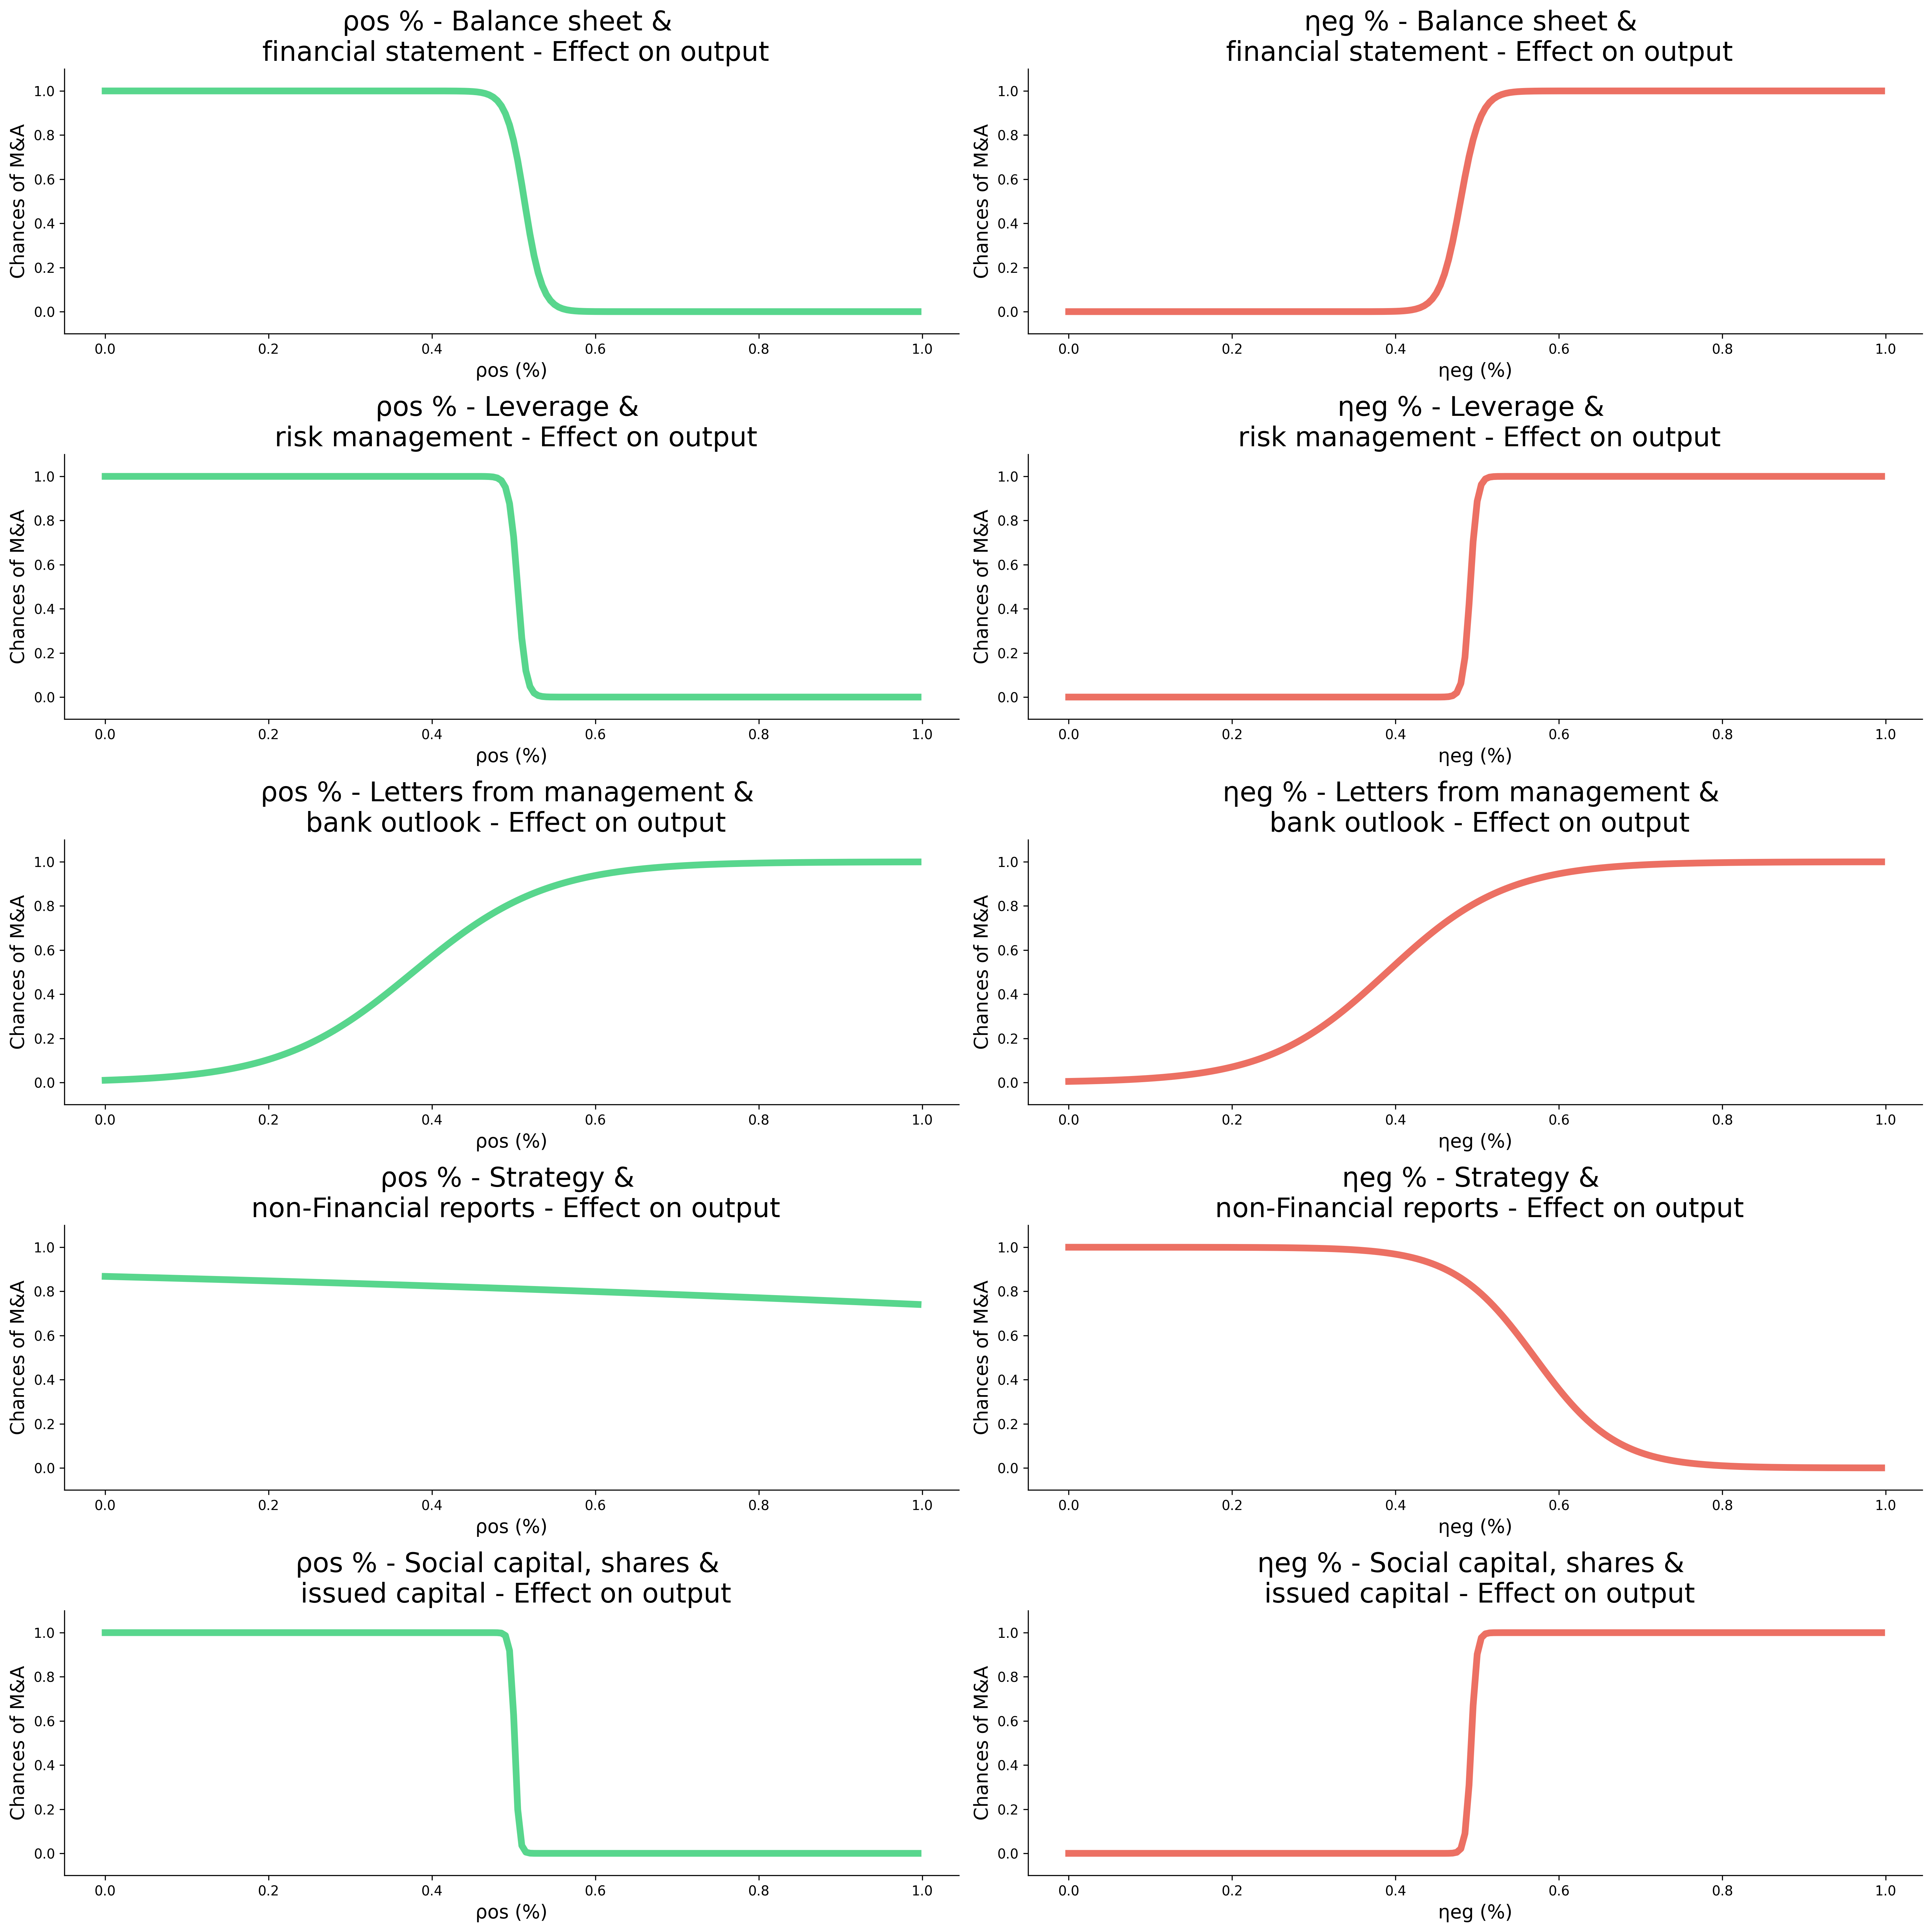

In [158]:
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=5, dpi=300)
fax = axes.flatten()

cols = ['pos_cluster_1', 'neg_cluster_1', 'pos_cluster_2', 'neg_cluster_2', 'pos_cluster_3', 'neg_cluster_3', 'pos_cluster_4', 
        'neg_cluster_4','pos_cluster_0',  'neg_cluster_0']

titles = {
    '1': 'Balance sheet & \n financial statement',
    '2': 'Leverage & \n risk management',
    '3': 'Letters from management & \n bank outlook',
    '4': 'Strategy & \n non-Financial reports',
    '5': 'Social capital, shares & \n issued capital',
}

model_logreg = load(path_modelo_logreg)

for ax, col in zip(fax, cols):
    variable = np.arange(0,1,0.005)
    dataframe = np.repeat([np.array(X_train.mean())], len(variable) , axis=0)

    dataframe = pd.DataFrame(dataframe, columns=X.columns)
    dataframe[col] = variable
    
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)
    var_name = col.split('_')
    var_sent = 'ρos' if var_name[0]=='pos' else 'ηeg'
    line_color = '#58d68d' if var_name[0]=='pos' else '#ec7063'
    var_clst = var_name[-1] if var_name[-1] != "0" else "5"
    
    sns.lineplot(y=model_logreg.predict_proba(dataframe)[:,1], x=variable, ax=ax, linewidth=5, color=line_color)
    
    ax.set_title(f'{var_sent} % - {titles[var_clst]} - Effect on output', size=20)
    ax.set_ylim([-0.1,1.1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f'{var_sent} (%)', size=14)    
    ax.set_ylabel(f'Chances of M&A', size=14)

plt.tight_layout()
plt.show()

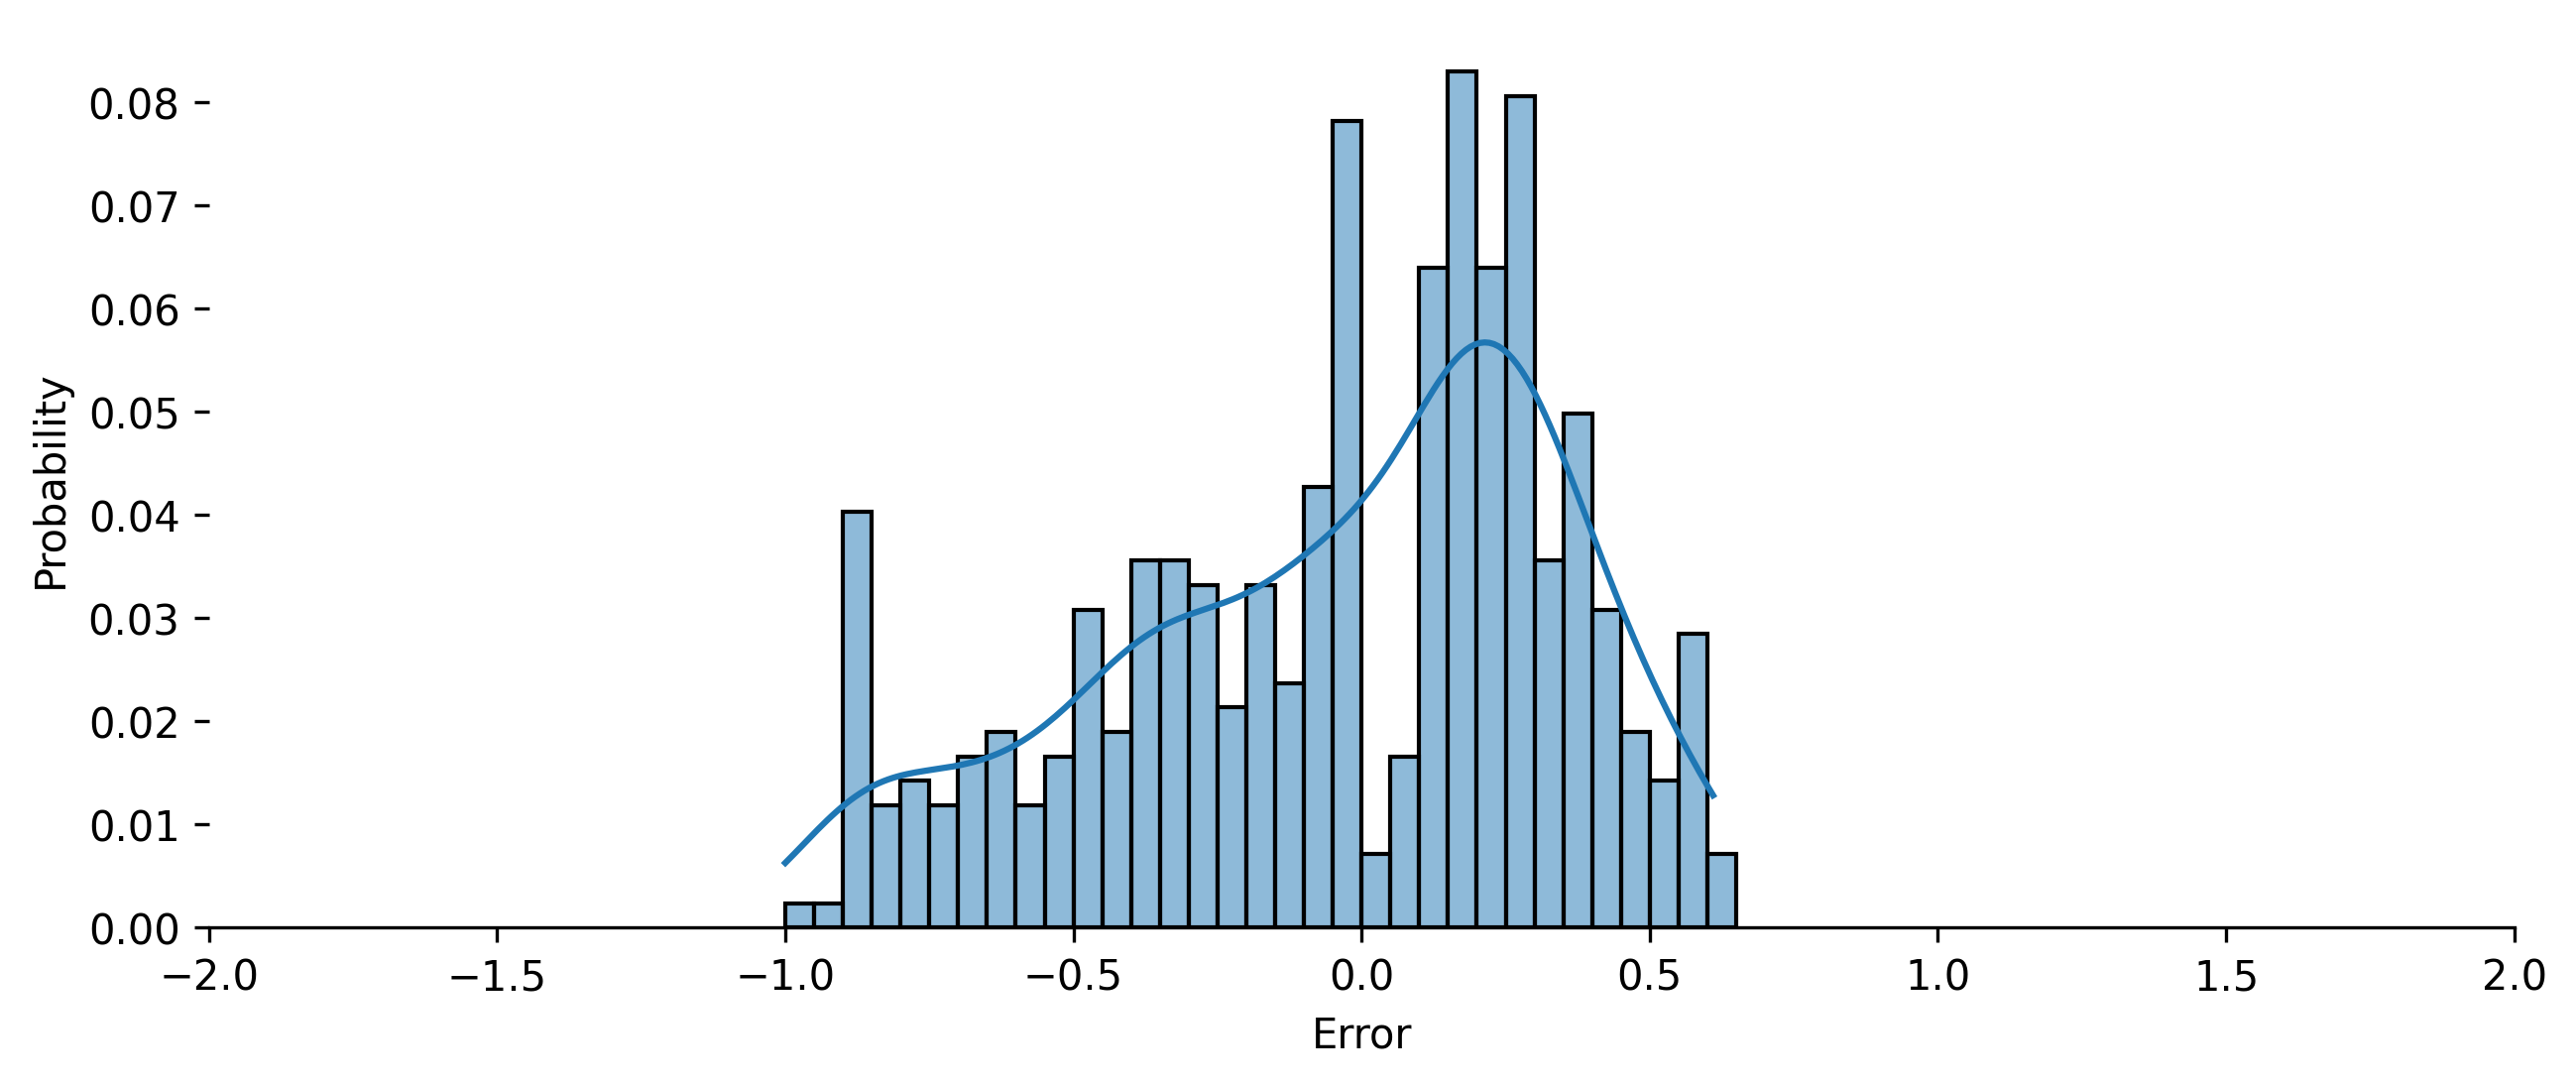

In [69]:
fig, ax = plt.subplots(figsize=(10,4), dpi=300)
sns.histplot(result.resid_generalized, stat='probability', kde=True, binwidth=0.05)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([-2,2])
ax.set_xlabel('Error')
plt.show()

In [24]:
model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [25]:
model.fit(X_res, y_res)

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

### Checkpoint del Modelo:

In [36]:
dump(model, path_modelo_logreg)

['../Data/MODELS/merger_logreg.joblib']

In [26]:
model['logreg'].coef_

array([[-1.06697299, -1.24607649, -1.32978443,  0.16114794, -0.02093655,
         0.90065416,  0.62614672,  0.58214956,  0.0985781 , -0.16685029]])

In [31]:
y_pred = logit_model.predict(X_test)

y_true = np.array(y_test)

ValueError: shapes (294,11) and (67,11) not aligned: 11 (dim 1) != 67 (dim 0)

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86        64
           1       0.12      0.67      0.20         3

    accuracy                           0.76        67
   macro avg       0.55      0.72      0.53        67
weighted avg       0.94      0.76      0.83        67



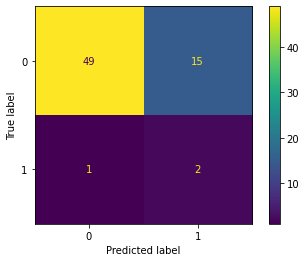

In [30]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

In [34]:
model.predict_proba(X_test)[:,1]

array([3.11634040e-01, 1.04534016e-01, 4.48056491e-01, 6.68037041e-05,
       7.58178362e-03, 4.61671315e-01, 1.60569747e-01, 5.52359465e-02,
       2.43180124e-01, 3.76385434e-01, 3.59548395e-01, 4.94334504e-01,
       5.22532306e-02, 4.91427632e-02, 2.45756162e-01, 3.62983282e-01,
       7.22848689e-01, 3.62875182e-02, 2.65633613e-01, 2.00914626e-01,
       4.31149702e-01, 5.26308449e-01, 6.69777738e-01, 8.12551871e-01,
       8.11993955e-01, 3.70960201e-01, 9.65162279e-02, 3.74489616e-01,
       6.90482250e-01, 4.38431277e-03, 4.64324764e-01, 4.40860221e-01,
       5.19068343e-01, 6.07255849e-01, 1.74534798e-01, 2.80727118e-01,
       8.49127955e-01, 2.00461560e-01, 1.83052840e-01, 7.79194882e-01,
       3.27476898e-01, 3.21098377e-01, 1.65996812e-03, 1.38953531e-01,
       2.60299823e-01, 3.76470169e-02, 2.02059923e-01, 1.79043787e-05,
       2.39006245e-02, 8.12416945e-01, 3.36972965e-01, 4.18993926e-01,
       5.84557023e-01, 4.17816000e-01, 4.78443956e-01, 8.36164858e-02,
      

In [38]:
res, time = predict_merger(data, 
               path_modelo_w2v,
               path_modelo_clustering,
               path_modelo_logreg,
               timeit=True
              )

Tokenizing...


100%|██████████████████████████████████████████████████████████████████████████████████████| 1202495/1202495 [00:07<00:00, 171226.81it/s]


Aplicando Word2Vec...


100%|███████████████████████████████████████████████████████████████████████████████████████| 1202495/1202495 [01:03<00:00, 18881.36it/s]


Aplicando Clustering...
Preparando Dataset...
Cargando Modelo...
Haciendo Predicción...
